In [2]:
from text_patterns import get_imp 
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-darkgrid')

/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_57391/3465311925.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Workflow

Take each subset of sentences that were extracted from:

Population: any transcript that contained zoning term

Subset: from population, any sentence that contained zoning area (based on locations brought up most often from the zoning popultion)

For each subset, we will visualize the bi-gram and tri-gram aggregation to identify what context was discussed around the rezoning area.

##### Todo: see if we can loop through each subset area

Decided to create subset for each df and do manual review.

In [229]:
case_study = pd.read_pickle('../../../data/odw/zoning_case_studies/soho_noho_CT_case_study_v1.pkl')

{'soho_noho': ['soho', 'noho', 'china town', 'chinatown']}

let's drop any transcript where it doesn't even mention soho noho rezoning

In [221]:
case_study[case_study['fullTranscript'].str.contains('open new york', case=False)].shape

(11, 10)

In [230]:
searchfor = ['soho', 'noho']

In [231]:
# drop these
case_study[~(case_study.fullTranscript.str.contains('|'.join(searchfor), case=False))].shape

(167, 10)

In [54]:
# sanity check passed
case_study[~(case_study.fullTranscript.str.contains('|'.join(searchfor), case=False))].head(1)

,_id,videoURL,normalizedName,publishDate,title,fullTranscript,lengthSeconds,wordCountFullTranscript,wordCountSummary,key_sentence
10,5fe7e244539a4d487dc18b81,https://www.youtube.com/watch?v=ZG4Wwc-hDXU,Manhattan Community Board 3,2020-10-23,Manhattan - Executive Committee Meeting,"One is in the room: may is here Jackie's here,...",2:22:28,"{'parks': 36, 'funding': 28, 'order': 26, 'bud...","{'beginning': 6, 'transportation': 6, 'service...","{So this, these capital priorities were given ..."


In [232]:
# filter out
case_study = case_study[(case_study.fullTranscript.str.contains('|'.join(searchfor), case=False))]

In [233]:
case_study.drop(columns=['fullTranscript'], inplace=True)

In [234]:
# number of transcripts for Soho/Noho (Chinatown)
case_study.shape

(199, 9)

Filter out any transcript that has less than 1 sentence mention and inward is trigger, to remove FP. If also not in CB12

In [235]:
case_study.loc[:, 'num_sent'] = case_study.key_sentence.apply(lambda x: len(x))

<AxesSubplot: >

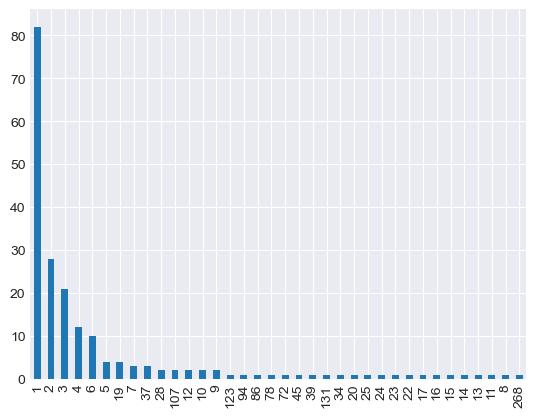

In [59]:
case_study.sort_values('num_sent')['num_sent'].value_counts().plot(kind='bar')

We see once we drop the transcripts about Chinatown, now CB2 and CB1 are the top

Curious why we see CB8 so often

In [61]:
case_study.normalizedName.value_counts().head()

Manhattan Community Board 2        51
Manhattan Community Board 1        25
NYC Department of City Planning    23
Manhattan Community Board 8        16
Manhattan Community Board 3        16
Name: normalizedName, dtype: int64

In [10]:
case_study.normalizedName.value_counts().head()

Manhattan Community Board 3        74
Manhattan Community Board 1        67
Manhattan Community Board 2        52
NYC Department of City Planning    25
Manhattan Community Board 8        20
Name: normalizedName, dtype: int64

Makes sense most meetings are from CB3, CB1, CB2

In [62]:
case_study[(case_study.num_sent == 1)].normalizedName.value_counts()

Manhattan Community Board 1        11
Manhattan Community Board 8         9
NYC Department of City Planning     9
Manhattan Community Board 4         7
Manhattan Community Board 6         6
Manhattan Community Board 7         5
Queens Community Board 1            4
Manhattan Community Board 5         4
Manhattan Community Board 3         4
Brooklyn Community Board 7          3
Manhattan Community Board 2         3
Brooklyn Community Board 6          3
Bronx Community Board 12            3
Brooklyn Community Board 14         2
Brooklyn Community Board 1          2
Manhattan Community Board 12        1
Brooklyn Community Board 4          1
Brooklyn Borough President          1
Brooklyn Community Board 2          1
Queens Community Board 3            1
Brooklyn Community Board 9          1
Brooklyn Community Board 10         1
Name: normalizedName, dtype: int64

Not expecting any FP since spelling is more straightforward

In [423]:
#case_study.loc[(case_study.num_sent == 1) & (case_study.normalizedName != "Manhattan Community Board 12"), 'false_pos?' ] = True

In [424]:
#case_study['false_pos?'].fillna(False, inplace=True)

We will explode the sentences, then filter out when Inward is the sentence with false_pos? potential.

In [16]:
case_study.head(1)

,_id,videoURL,normalizedName,publishDate,title,lengthSeconds,wordCountFullTranscript,wordCountSummary,key_sentence,num_sent
1,5fe7e243539a4d487dc18b66,https://www.youtube.com/watch?v=Ftq9Z4DFmE4,Manhattan Community Board 2,2020-10-23,Monthly Meeting,2:22:36,"{'restaurants': 24, 'dining': 22, 'plan': 18, ...","{'dining': 7, 'voting': 6, 'restaurants': 6, '...","Zoning push for Soho, Noho I think.",19


In [236]:
# each sentence its own row
case_study = case_study.explode('key_sentence')

In [241]:
case_study[case_study['key_sentence'].str.contains('open new york', case=False)].key_sentence.value_counts()

My name is: will thomas I'm a resident of the east village and I'm here to support the rezoning of sohonoho as the executive director of open New York, an independent all-volunteer pro housing organization?\n                                                                                                                                                                                                                                                                                               1
My name is zeke luger, so the Department Of City Planning has had one main community partner for the Soho rezoning and that's open New York.\n                                                                                                                                                                                                                                                                                                                                                                 1
I talk

In [65]:
# not sure if Chinatown will dilute converation
case_study[(case_study['num_sent'] == 1) & (case_study['normalizedName'] =='Manhattan Community Board 8')].key_sentence.value_counts().head()

What a city needs to thrive on is mixed economic opportunities throughout the city, so, on the one hand, it's justification for the rezoning of or the up, zoning or whatever it is of Noho Soho to put affordable housing in there, but somehow for this, it's not required and they go into the boroughs where the land is cheaper.\n                            1
We hope that some of those are temporarily closed and that they're going to come back, but it's still pretty concerning I know: Matt is on the zoom madison avenue between east 57th and east 59th street had an astounding ground floor vacancy rate of nearly 40 percent at the end of the year at the end of 2020, Soho has also they're at about 30 vacancy    1
Is we didn't name any specific neighborhoods I mean we are supportive of the rezoning in Soho or at least New York housing conferences, united for housing hasn't taken a specific position, I'm not so we didn't name any specific, neighborhoods and I haven't gotten into the weeds.       

Interesting to see CB8 talking about Soho Noho and other locations.

In [66]:
case_study.shape

(2047, 10)

In [67]:
case_study.key_sentence.nunique()

2040

In [68]:
case_study[case_study.key_sentence.duplicated()]

,_id,videoURL,normalizedName,publishDate,title,lengthSeconds,wordCountFullTranscript,wordCountSummary,key_sentence,num_sent
1151,6175fd074f90e24494ea8685,https://www.youtube.com/watch?v=cNKLpOzYPt0,NYC Department of City Planning,2021-10-21,City Planning Commission Review Session + Spec...,1:31:59,"{'floor': 77, 'applicant': 56, 'street': 56, '...","{'floor': 16, 'street': 14, 'applicant': 13, '...",So moving on to future votes on Wednesday Octo...,1
1152,6175fe064f90e24494ea868b,https://www.youtube.com/watch?v=YACZ8c4z-lw,NYC Department of City Planning,2021-10-22,City Planning Commission Public Meeting,2:12:56,"{'commissioner': 91, 'commission': 58, 'calend...","{'calendar': 23, 'planning': 13, 'development'...",The Soho Noho neighborhood plan stands for the...,6
1152,6175fe064f90e24494ea868b,https://www.youtube.com/watch?v=YACZ8c4z-lw,NYC Department of City Planning,2021-10-22,City Planning Commission Public Meeting,2:12:56,"{'commissioner': 91, 'commission': 58, 'calend...","{'calendar': 23, 'planning': 13, 'development'...",Amendments concerning the Soho Noho neighborho...,6
1152,6175fe064f90e24494ea868b,https://www.youtube.com/watch?v=YACZ8c4z-lw,NYC Department of City Planning,2021-10-22,City Planning Commission Public Meeting,2:12:56,"{'commissioner': 91, 'commission': 58, 'calend...","{'calendar': 23, 'planning': 13, 'development'...",I do remember a conversation with Margaret Che...,6
1152,6175fe064f90e24494ea868b,https://www.youtube.com/watch?v=YACZ8c4z-lw,NYC Department of City Planning,2021-10-22,City Planning Commission Public Meeting,2:12:56,"{'commissioner': 91, 'commission': 58, 'calend...","{'calendar': 23, 'planning': 13, 'development'...",I think it burdens the few remaining jail wqa ...,6
1152,6175fe064f90e24494ea868b,https://www.youtube.com/watch?v=YACZ8c4z-lw,NYC Department of City Planning,2021-10-22,City Planning Commission Public Meeting,2:12:56,"{'commissioner': 91, 'commission': 58, 'calend...","{'calendar': 23, 'planning': 13, 'development'...",It also offers meaningful supports for the art...,6
2328,63d121a23423df16f196f8d1,https://www.youtube.com/watch?v=019VFs4KpUE,Manhattan Community Board 2,2023-01-23,Full Board Meeting,3:38:08,"{'president': 24, 'building': 24, 'towers': 23...","{'buildings': 6, 'program': 6, 'boards': 6, 'd...",Clothes and welcome to Chinatown is hosting a ...,3


There really shouldn't be any duplciates

In [237]:
case_study.drop_duplicates(subset='key_sentence', inplace=True)

In [22]:
# inwood
case_study._id.nunique()

363

In [111]:
# Soho/Noho (Chinatown) case study
case_study.shape

(2040, 9)

In [238]:
# promote more matches

case_study.loc[:, 'key_sentence'] = case_study.key_sentence.apply(lambda x: x.replace('soho noho', 'sohonoho'))
case_study.loc[:, 'key_sentence'] = case_study.key_sentence.apply(lambda x: x.replace('Soho Noho', 'sohonoho'))

In [242]:
remove_all = ['new york', 'new york city', 'community board', 'just want', 'make sure', 'neighborhood plan', 'plan course know',
'rezoning area', 'neighborhood rezoning', 'department city planning', 'city planning commission', 'brooklyn community district', 
'land use committee', 'resolution today provisions', 'today provisions limited', 'line recently special', 'zoning resolution today']

In [243]:
def get_imp_depr(bow,mf,ngram):
    import pandas as pd
    import numpy as np
    # creates BOW
    import sklearn.feature_extraction.text as text

    tfidf=text.CountVectorizer(ngram_range=(1, ngram), max_features=mf, stop_words='english')
    matrix=tfidf.fit_transform(bow)
    return pd.Series(np.array(matrix.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False).head(1000)


In [244]:
def get_imp(bow,mf,ngram, remove_boiler_list):
    import pandas as pd
    import numpy as np
    # creates BOW
    import sklearn.feature_extraction.text as text

    tfidf=text.CountVectorizer(ngram_range=(ngram, ngram), max_features=mf, stop_words='english')
    matrix=tfidf.fit_transform(bow)#.toarray()
    df_output = pd.Series(np.array(matrix.sum(axis=0))[0],
        index=tfidf.get_feature_names()).sort_values(ascending=False).head(1000)

    df_output = pd.DataFrame(df_output).reset_index().rename(columns={'index':'n_gram', 0:'term frequency'})

    # filter out terms
    searchfor = remove_boiler_list + remove_all
    df_output = df_output[~df_output.n_gram.str.contains('|'.join(searchfor))]  
    return df_output


In [245]:
def create_bigram_trigram(df_with_key_sentence, remove_terms: list):

    # explode sentences
    #case_study = df_with_key_sentence.explode('key_sentence')

    # create list of all sentences
    bow= case_study['key_sentence'].tolist()

    ### calculate trends
    total_data = get_imp(bow, mf=100,ngram=1, remove_boiler_list=remove_terms)
    total_data_bigram = get_imp(bow=bow,mf=100,ngram=2, remove_boiler_list=remove_terms)
    total_data_trigram = get_imp(bow=bow,mf=100,ngram=3, remove_boiler_list=remove_terms)

    return total_data, total_data_bigram, total_data_trigram
    #return case_study, bow




In [216]:
case_study._id.nunique()

198

In [353]:
total_data, total_data_bigram, total_data_trigram = create_bigram_trigram(case_study, soho_noho_remove)

/Users/sarah/opt/anaconda3/envs/bp_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/sarah/opt/anaconda3/envs/bp_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/sarah/opt/anaconda3/envs/bp_analysis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [278]:
gowanus_remove = ['red hook', 'know gowanus mix', 'gowanus neighborhood brooklyn']

In [615]:
inwood_remove = ['inwood washington heights', 'know washington heights', 'washington heights inwood', 
'washington heights just', 'washington heights inward', 'washington nights inwood', 'heights inwood just', 
'harlem washington heights', 'inwood zoning district', 'inwood rezoning know', 'washington ice inwood', 'community washington heights',
'east harlem inwood', 'heights inwood community', 'inwood east harlem', 'like washington heights', 'south washington heights', 'right washington heights']

In [273]:
soho_noho_remove = ['sohonoho rezoning', 'sohonoho neighborhood', 'envision sohonoho', 
'sohonoho plan',  'soho noho rezoning', 'plan soho noho', 'know don know', 'rezoning soho noho',
'llc doing business', 'like upper east', 'nyc gov sohonoho', 'nyc gov soho noho', 'noho soho rezoning']

Perhaps should add washington heights as a synonym to searching for inwood.

Saw a lot of boilerplate language about how limited the scope is. Such as resolution today provisions.

In [32]:
file_path = '../../../data/odw/zoning_case_studies/histogram/'

In [370]:
def plot_data(df, title):
    df.head(15).plot('group', kind="barh",figsize=(10,10),color='#ED315D', legend=False)
    plt.xlabel('Term Frequency', size=15)
    plt.ylabel('n-gram', size=15)
    plt.title(f'Block Party Transcript Text Analysis', size=15)
    plt.savefig(f'{file_path}/{title}text_analysis_top15.svg', format='svg', dpi=1200, bbox_inches = "tight")
    plt.show()
    

Join similar terms

In [489]:
len(total_data_trigram)

79

In [491]:
total_data_trigram.group.nunique()

68

In [356]:
total_data_trigram.loc[:, 'n_gram'] = total_data_trigram.n_gram.apply(lambda x: x.replace('sohonoho', 'soho/noho'))
total_data_trigram.loc[:, 'n_gram'] = total_data_trigram.n_gram.apply(lambda x: x.replace('ve lived soho', "i've lived in soho"))
total_data_trigram.loc[:, 'n_gram'] = total_data_trigram.n_gram.apply(lambda x: x.replace('soho noho', 'soho/noho'))

In [357]:
# default each group as the name
total_data_trigram.loc[:, 'group'] = total_data_trigram.n_gram

In [310]:
# before aggregating
total_data_trigram.groupby('group', as_index=False)[['term frequency']].sum().sort_values('term frequency', ascending=False).head(20)

,group,term frequency
21,chinatown little italy,20
61,soho broadway initiative,17
4,231 grand street,14
62,soho cast iron,13
65,soho/noho chinatown,13
67,soho/noho working group,11
19,cast iron historic,9
23,chinatown lower east,8
36,i've lived in soho,8
38,iron historic district,8


In [358]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('iron'), 'group'] = 'soho cast iron'

In [359]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('cast'), 'group'] = 'soho cast iron'

In [360]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('affordable housing'), 'group'] ='build affordable housing'

In [361]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('231'), 'group'] ='231 grand street'

In [362]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('chinatown'), 'group'] ='members chinatown community \n (similar mentions grouped)'

In [363]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('000 square'), 'group'] ='000 square feet'

In [364]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('draft'), 'group'] ='draft scope of work'

In [365]:
total_data_trigram.loc[total_data_trigram.n_gram.str.contains('chinatown')][['n_gram', 'term frequency']]

,n_gram,term frequency
2,chinatown little italy,20
6,soho/noho chinatown,13
13,chinatown lower east,8
21,lower east chinatown,6
55,members chinatown community,4
59,york city chinatown,4
62,chinatown east village,4
63,chinatown low east,4
64,chinatown noho soho,4
65,chinatown working group,4


In [344]:
total_data_trigram.groupby('group', as_index=False)[['term frequency']].sum().sort_values('term frequency', ascending=False).head(20)

,group,term frequency
29,members chinatown community \n (similar mentio...,78
40,soho cast iron,41
11,build affordable housing,33
3,231 grand street,22
39,soho broadway initiative,17
0,000 square feet,11
44,soho/noho working group,11
22,i've lived in soho,8
26,long time resident,7
4,250 water street,7


May want to drop any transcript if full transcript does not mention soho/noho...

In [349]:
total_data_trigram_v1 = total_data_trigram.groupby('group', as_index=False)[['term frequency']].sum().sort_values('term frequency', ascending=False)

In [378]:
total_data_trigram_v1.loc[:, 'group'] = total_data_trigram_v1.group.apply(lambda x: x.title())

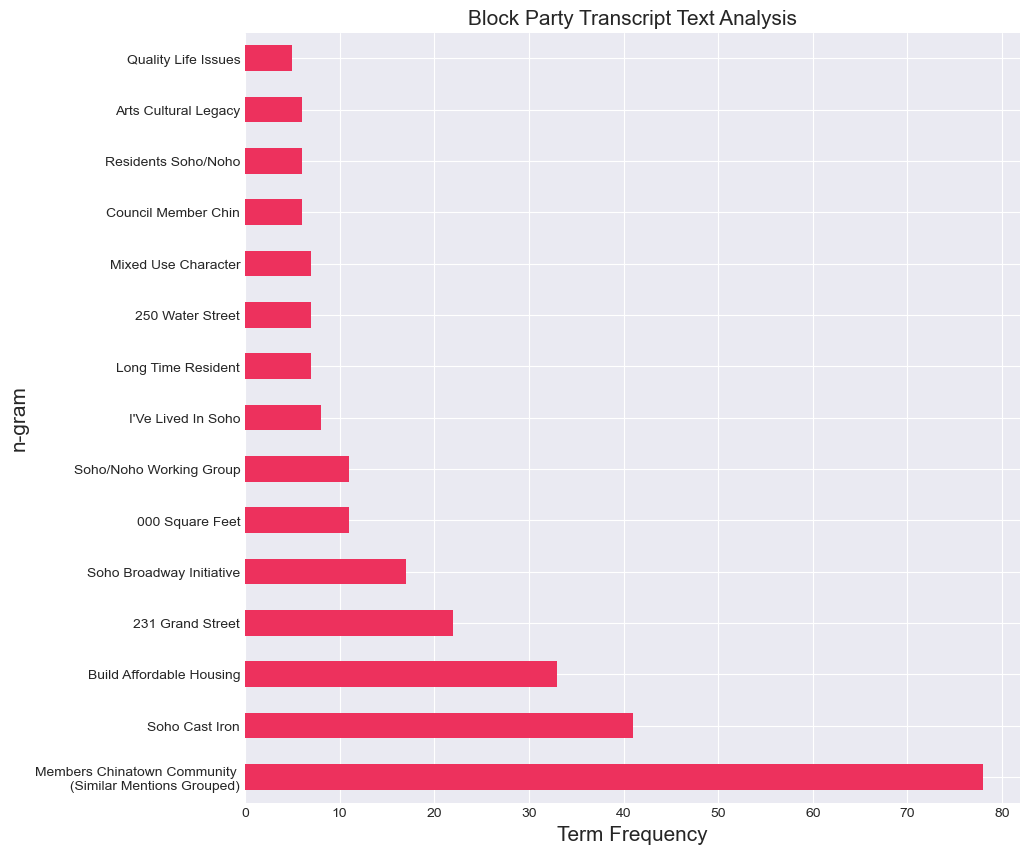

In [379]:
# final version 
plot_data(total_data_trigram_v1, 'Soho Noho')

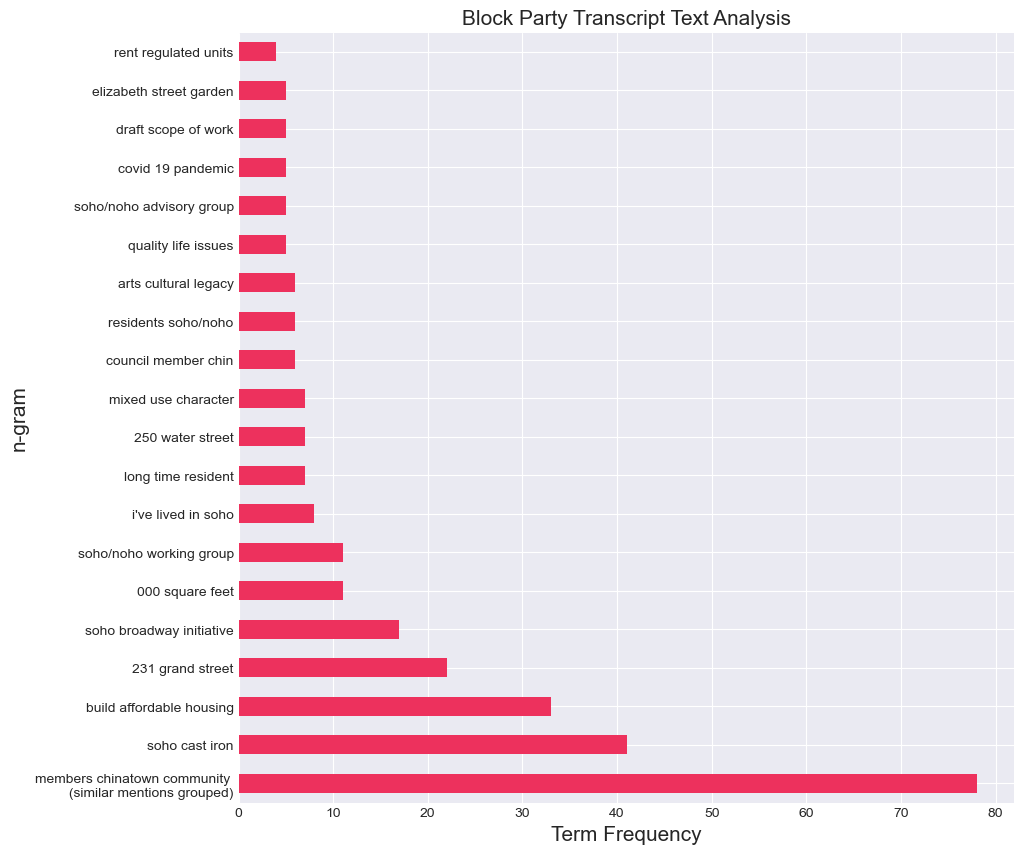

In [350]:
# final version 
plot_data(total_data_trigram_v1, 'Soho Noho')

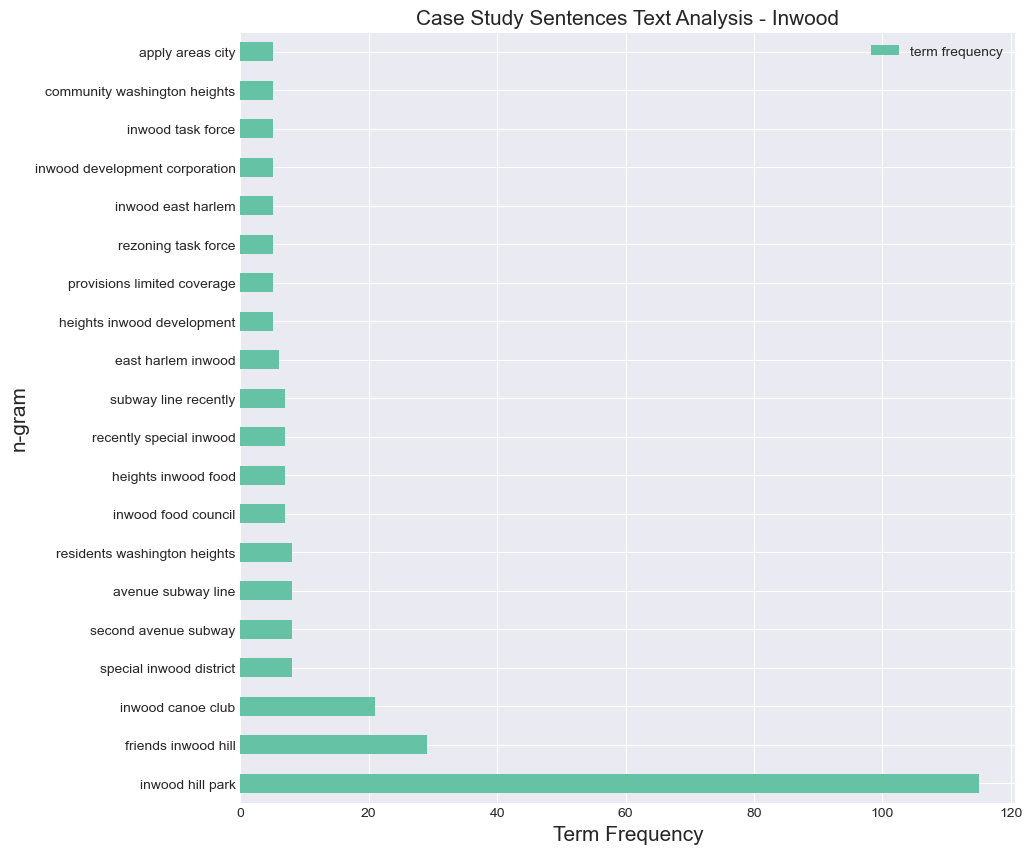

In [338]:
# v0
plot_data(total_data_trigram, 'Inwood')

In [350]:
case_study.head()

,_id,videoURL,normalizedName,publishDate,title,lengthSeconds,wordCountFullTranscript,wordCountSummary,key_sentence
3,5fe7e243539a4d487dc18b6b,https://www.youtube.com/watch?v=WYAIXLdB9wI,Manhattan Community Board 12,2020-06-15,Executive Committee Virtualmeeting,2:12:43,"{'report': 36, 'business': 19, 'traffic': 18, 'summer': 16, 'businesses': 14, 'school': 14, 'parks': 12, 'resolutions': 12, 'budget': 11, 'orientation': 11}","{'business': 6, 'traffic': 5, 'report': 4, 'plan': 4, 'seniors': 4, 'summer': 3, 'budget': 3, 'interest': 3, 'parks': 3, 'resolutions': 3}","There was a lot of concern that we were looking to expand barbecuing in Inwood Hill Park, specifically on the Indian Road Lon."
3,5fe7e243539a4d487dc18b6b,https://www.youtube.com/watch?v=WYAIXLdB9wI,Manhattan Community Board 12,2020-06-15,Executive Committee Virtualmeeting,2:12:43,"{'report': 36, 'business': 19, 'traffic': 18, 'summer': 16, 'businesses': 14, 'school': 14, 'parks': 12, 'resolutions': 12, 'budget': 11, 'orientation': 11}","{'business': 6, 'traffic': 5, 'report': 4, 'plan': 4, 'seniors': 4, 'summer': 3, 'budget': 3, 'interest': 3, 'parks': 3, 'resolutions': 3}","Most wonderful events in Inwood, Hill Park on the Gaelic fields, is going virtual."
3,5fe7e243539a4d487dc18b6b,https://www.youtube.com/watch?v=WYAIXLdB9wI,Manhattan Community Board 12,2020-06-15,Executive Committee Virtualmeeting,2:12:43,"{'report': 36, 'business': 19, 'traffic': 18, 'summer': 16, 'businesses': 14, 'school': 14, 'parks': 12, 'resolutions': 12, 'budget': 11, 'orientation': 11}","{'business': 6, 'traffic': 5, 'report': 4, 'plan': 4, 'seniors': 4, 'summer': 3, 'budget': 3, 'interest': 3, 'parks': 3, 'resolutions': 3}","I remembered what my reso is: it's very uncontroversial, it's a reso in support of urban gardening and we had a fantastic presentation by the Washington Heights Inwood food council, and so we unanimously passed a resolution in support of trying to find more spaces that are appropriate for more of that activity."
3,5fe7e243539a4d487dc18b6b,https://www.youtube.com/watch?v=WYAIXLdB9wI,Manhattan Community Board 12,2020-06-15,Executive Committee Virtualmeeting,2:12:43,"{'report': 36, 'business': 19, 'traffic': 18, 'summer': 16, 'businesses': 14, 'school': 14, 'parks': 12, 'resolutions': 12, 'budget': 11, 'orientation': 11}","{'business': 6, 'traffic': 5, 'report': 4, 'plan': 4, 'seniors': 4, 'summer': 3, 'budget': 3, 'interest': 3, 'parks': 3, 'resolutions': 3}","So at the conclusion of the meeting was about eleven o'clock : I walked up to Inwood Hill Park checked out the signage took pictures of it, sent it to the parks."
9,5fe7e243539a4d487dc18b78,https://www.youtube.com/watch?v=mcuu4VrwZto,Manhattan Community Board 12,2020-09-22,Manhattan General Meeting,3:40:24,"{'report': 36, 'school': 23, 'seniors': 23, 'street': 21, 'resolutions': 20, 'rest': 20, 'businesses': 17, 'safety': 17, 'right': 16, 'planning': 15}","{'report': 7, 'shelter': 7, 'case': 6, 'situation': 5, 'needs': 5, 'school': 5, 'resolutions': 5, 'safety': 5, 'allegations': 4, 'conversations': 4}","We spoke to Eliasar about creating an Inwood task force and supporting you know the identification of you know, Non-cb member stakeholders, and also just the you know, the logistics of running these meetings."


Doesn't make sense to see so many mentions of chelsea land use, let's see what the sentences were.

In [375]:
curious_df = case_study[case_study['key_sentence'].str.contains('ugly', case=False, regex=True)]

In [377]:
curious_df

,_id,videoURL,normalizedName,publishDate,title,lengthSeconds,wordCountFullTranscript,wordCountSummary,key_sentence,num_sent
973,610133a6789497467cbea0bb,https://www.youtube.com/watch?v=pzm8t94FjpE,Manhattan Community Board 2,2021-07-27,Community Board Meeting,3:58:22,"{'housing': 145, 'plan': 104, 'street': 57, 'n...","{'housing': 43, 'plan': 39, 'neighborhood': 12...","Landmarks are supposed to protect an area, oth...",107


In [376]:
curious_df.videoURL.value_counts().head()

https://www.youtube.com/watch?v=pzm8t94FjpE    1
Name: videoURL, dtype: int64

So they only talk about rezoning in a few transcripts, should 

In [368]:
curious_df._id.value_counts().head()

614875e7505a6d64a947d2bb    3
614b08a87e8d2790d494fa26    1
6150ac5f591ccbe025480ce8    1
616f6ae264b92b2f23222aca    1
6176037f4f90e24494ea8695    1
Name: _id, dtype: int64

In [374]:
curious_df.key_sentence.value_counts()

Soho fire escapes are iconic and it our fire escapes, are very much part of what most people think of when they see Soho cast iron buildings.                                                                                                                                                                                                                                                                                                                                                                                                                                                             1
Yes, william, since the buildings within the Soho cast iron, historic district, is it going to go through the landmarks approval process?\n                                                                                                                                                                                                                                                                                 

In [254]:
# wow there are unique sentences from different transcripts that have such similar verbatim!
curious_df._id.nunique() == len(curious_df)

True

In [245]:
curious_df.key_sentence.explode()

672                                                                                                                                                                                                                                                                                                                                                                              However, in the zoning resolution today, these provisions have very limited coverage and only apply in a few areas of the city such as along the second avenue for the second avenue subway line and, most recently in the special Inwood district.\n
736                                                                                                                                                                                                                                                                                                                                                                                     However, 

proof that different meetings have almost same exact language

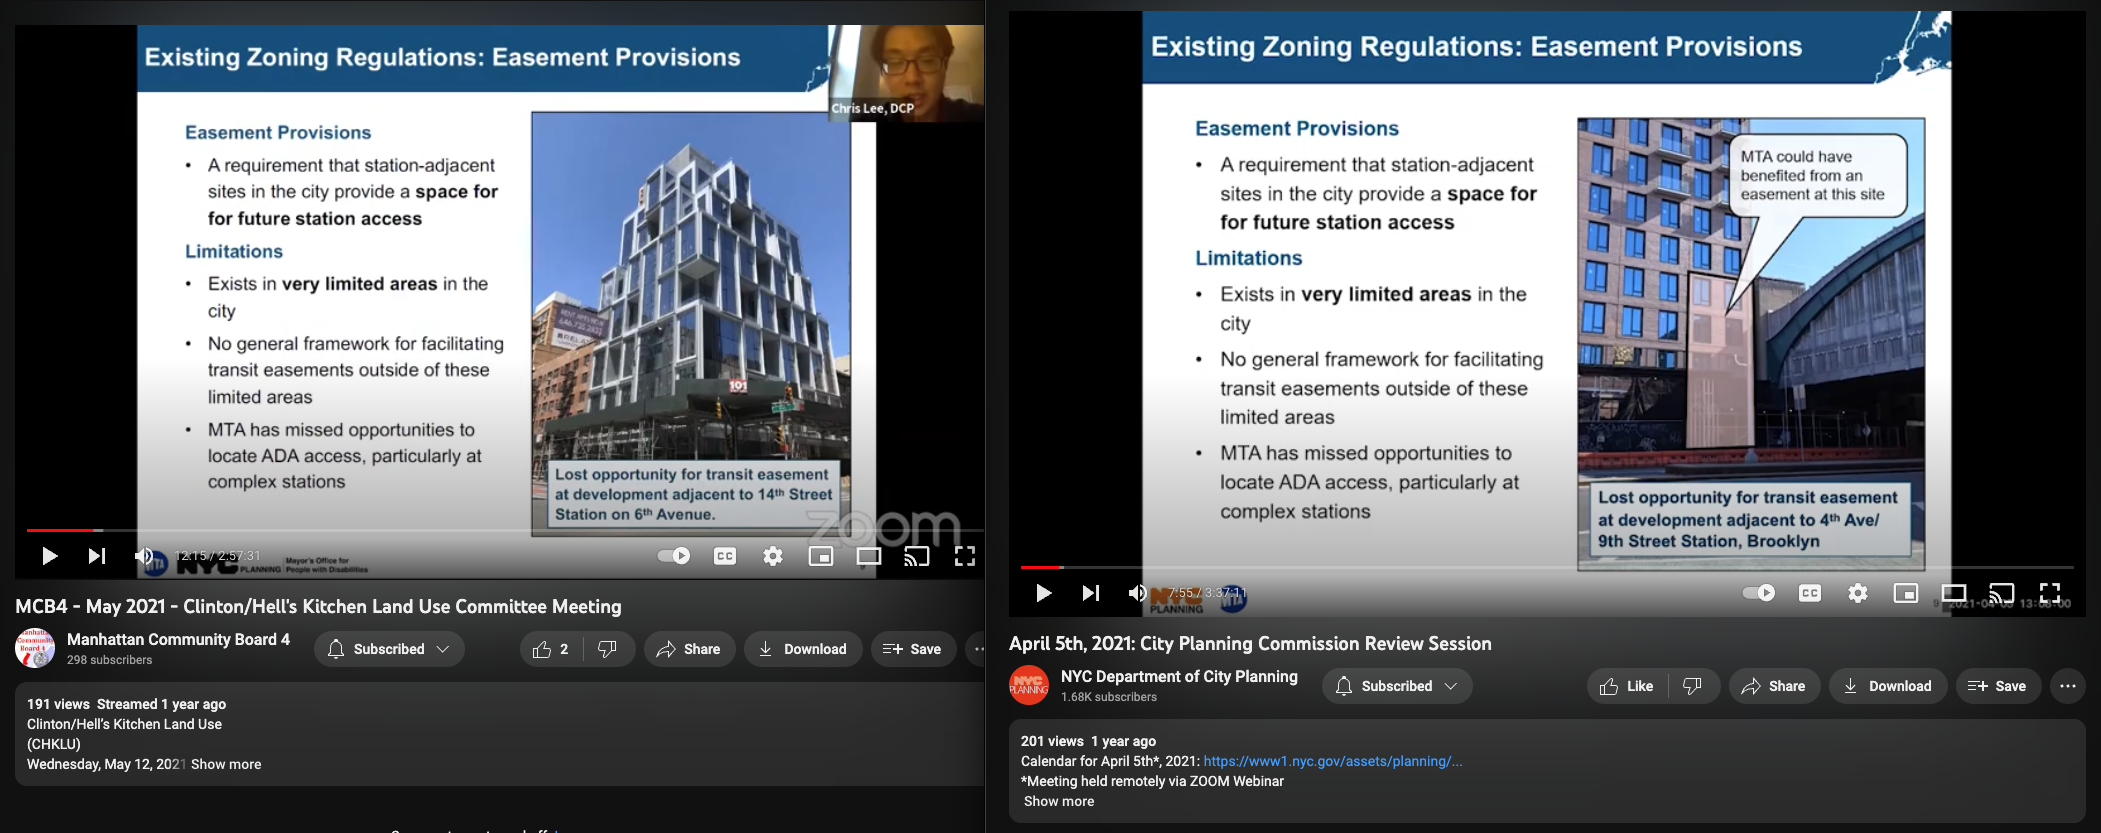

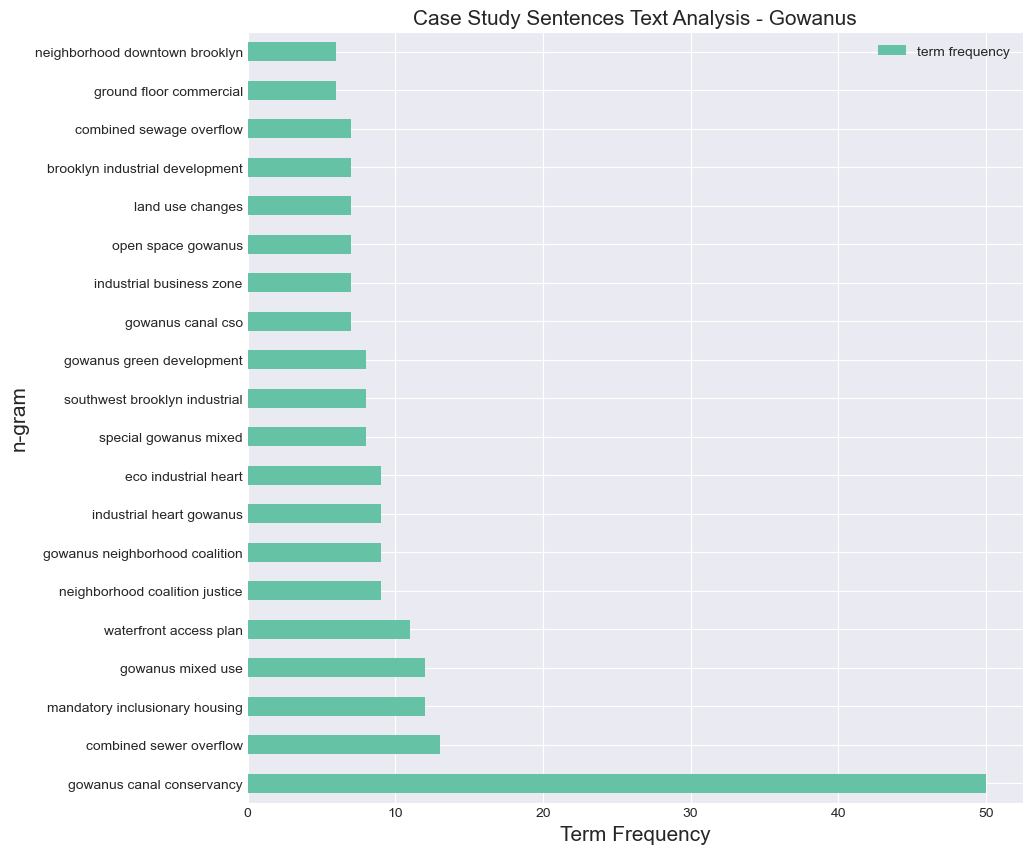

In [169]:
plot_data(total_data_trigram, 'Gowanus')

In [127]:
test = case_study.head()

In [130]:
test.key_sentence.value_counts()

{We just passed the loft bill in Bushwick, so that I think that we need to be very clear that it isn't that this is being handled remotely, that every other community group across the city, Gowanus industry city.}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [128]:
test[test.key_sentence.str.contains('land use changes')]

KeyError: "None of [Float64Index([nan, nan, nan, nan, nan], dtype='float64')] are in the [columns]"

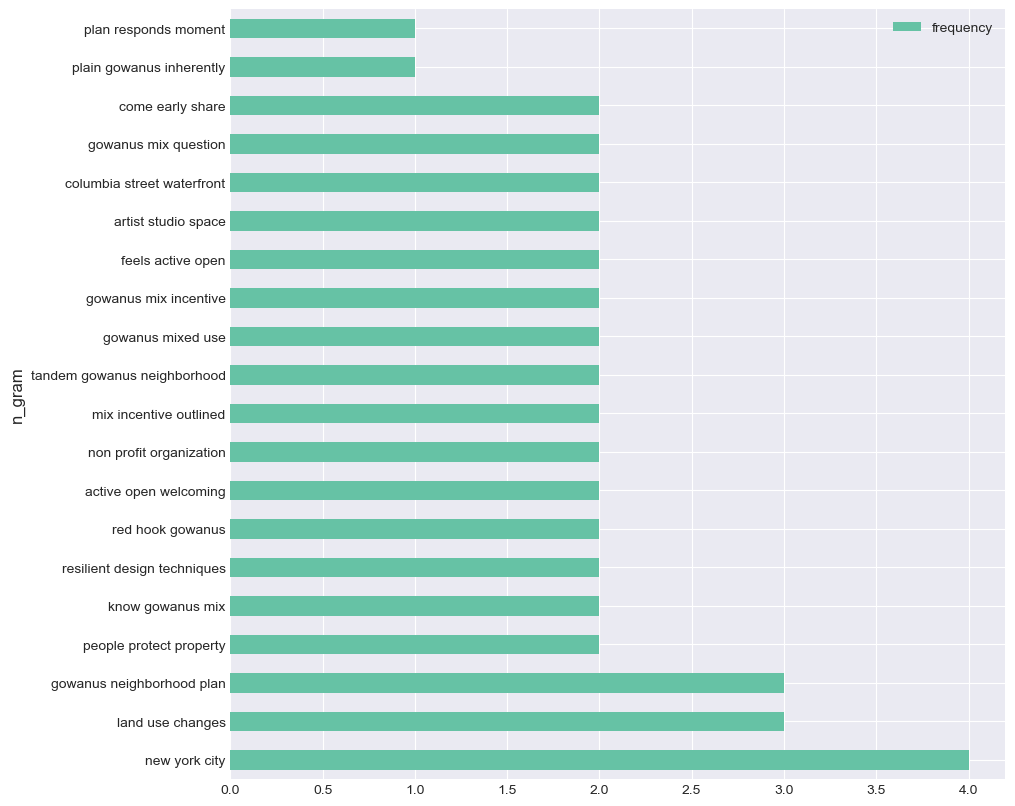

In [105]:
total_data_trigram.head(20).plot('n_gram', kind="barh",figsize=(10,10),colormap='Set2')
plt.show()